# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow import keras
import os
import time
import random
import glob # Khoa's stuff
import IPython.display

# Utilities
import scipy.io.wavfile as wav
from utils.audio_spectrogram import stft
from PIL import Image

# Models
from models.deepfake_generator import generator
from models.visual_quality_discriminator import quality_discriminator

# Test models

In [2]:
img = Image.open("./test_face.png")
img_arr = np.asarray(img)

# create a mask
img_masked = img_arr.copy()
img_masked[256//2:,...] = 0

# plt.imshow(img_masked)
# display the mask, and the output image
# cv2.imshow('Masked Image', img_masked)

# concatenate masked ground truth to pose prior
img_concat = np.concatenate([img_arr, img_masked], axis=2)

# normalize
img_concat = np.expand_dims(img_concat//255, axis=0)

img_arr = np.reshape(img_arr, newshape=(1, 256, 256, 3))

audio_samplerate, audio = wav.read("./test_audio.wav")
audio_arr = stft(audio, 2 ** 10) # what is this?
audio_arr = np.reshape(audio_arr, newshape=(1, 6, 513, 1))

print(img_concat.shape)
print(audio_arr.shape)

# Define models
gen = generator()
qual_disc = quality_discriminator()


generated_img = gen.predict([img_concat, audio_arr], batch_size=1)

print(generated_img.shape)
plt.imshow(generated_img[0, :, :, :])


(1, 256, 256, 6)
(1, 6, 513, 1)


AttributeError: 'KerasTensor' object has no attribute 'output'

# Plot Models

In [ ]:
keras.utils.plot_model(gen, 'generator_plot.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
keras.utils.plot_model(qual_disc, 'quality_discriminator_plot.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Constants

In [ ]:
EPOCHS = 5
BATCH_SIZE = 200
POSE_PRIOR = Image.open("./test_face.png") # constant for now
POSE_PRIOR = np.asarray(POSE_PRIOR)

# Get randomized dataset batch
We can't possibly hold everything at once

In [ ]:
def khoas_get_batch(batch_size):
    """
    Khoa's custom function
    The real stuff needs the real function
    """
    data_path = './test_data/'

    png_list = []
    for file in os.listdir(data_path):
        if file.endswith('png'):
            png_list.append(file)

    image_samples = []
    gen_input_samples = [] # Specifically to work with Huy's data, should change
    audio_samples = []

    for img_name in random.sample(png_list, batch_size):
        img_name = data_path+img_name
        name = img_name[:-4] # name of file without extension
        audio_name = name + '.wav'# name of audio file
        img = Image.open(img_name)
        img_arr = np.asarray(img)
        image_samples.append(img_arr//255)

        video_name = ''.join([i for i in name if not i.isdigit()])
        pose_prior_name = img_name

        # randomly choose a pose prior of the same person
        while pose_prior_name == img_name:
            pose_prior_name = random.choice(glob.glob(video_name+'*.png'))

        pose_prior = Image.open(pose_prior_name)
        pose_prior = np.asarray(pose_prior)

        img_masked = img_arr.copy()
        # create a mask
        img_masked[256//2:,...] = 0

        # concatenate masked ground truth to pose prior
        img_concat = np.concatenate([POSE_PRIOR, img_masked], axis=2)
        # expected shape (256, 256, 6)
        # normalize
        gen_input_samples.append(img_concat//255)

        audio_samplerate, audio = wav.read(audio_name)
        audio_arr = stft(audio, 2 ** 10) # what is this?
        audio_samples.append(audio_arr)

    image_samples = np.asarray(image_samples)
    gen_input_samples = np.asarray(gen_input_samples)
    audio_samples = np.asarray(audio_samples)
        
    # It should go without saying that the order needs to match
    return image_samples, gen_input_samples, audio_samples

# Define Loss Functions and Optimizers

In [ ]:
quality_discriminator_loss = keras.losses.BinaryCrossentropy(from_logits=True)
generator_loss = keras.losses.MeanAbsoluteError() # Also known as L1 reconstruction loss

generator_optimizer = tf.keras.optimizers.Adam(1e-3)
quality_discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

# Misc

# Process generator input data
Essentially a reference face (pose prior) concatenated channel-wise with the masked original face

In [ ]:
def process_gen_imgs(images): 
    """
    Assumes image is normalized beforehands and is a numpy array with shape (256, 256, 3)
    TODO: Random pose prior
    """
    output = []
    for img in images:
        img_masked = img.copy()
        # create a mask
        img_masked[256//2:,...] = 0

        # concatenate masked ground truth to pose prior
        img_concat = np.concatenate([POSE_PRIOR, img_masked], axis=2)
        # expected shape (256, 256, 6)
        output.append(img_concat)

    return output

In [ ]:
@tf.function
def train_step(images, gen_imgs, audio_samples):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen([gen_imgs, audio_samples], training=True)
        
        real_output = qual_disc(images, training=True)
        fake_output = qual_disc(generated_images, training=True)

        gen_loss = generator_loss(images, generated_images)
        disc_loss = quality_discriminator_loss(real_output, fake_output)

        gradients_of_generator =  gen_tape.gradient(gen_loss, gen.trainable_variables)
        gradients_of_quality_discriminator = disc_tape.gradient(disc_loss, qual_disc.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
        quality_discriminator_optimizer.apply_gradients(zip(gradients_of_quality_discriminator, qual_disc.trainable_variables))

# Train

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig("./generated_images/image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [ ]:
def train_in_batch(batch, epoch):
    start = time.time()

    train_step(batch[0], batch[1], batch[2])

    # Produces images for the GIF
    #display.clear_output(wait=True)
    print('Time for epoch {} is {} sec. Saving image.'.format(epoch+1, time.time()-start))
    generate_and_save_images(gen, epoch + 1, [img_concat, audio_arr]) # Maybe my face?
    # if (epoch+1) % 15 == 0:
    #     checkpoint.save(file_prefix = checkpoint_prefix)

    

Epoch 1 starting
Time for epoch 1 is 37.18096876144409 sec. Saving image.


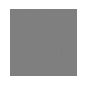

Epoch 2 starting
Time for epoch 2 is 33.958998918533325 sec. Saving image.


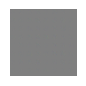

Epoch 3 starting
Time for epoch 3 is 33.36356806755066 sec. Saving image.


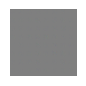

Epoch 4 starting
Time for epoch 4 is 35.685534715652466 sec. Saving image.


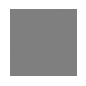

Epoch 5 starting
Time for epoch 5 is 34.097559452056885 sec. Saving image.


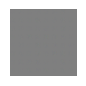

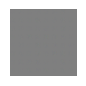

In [ ]:
for epoch in range(EPOCHS):
    print("Epoch {} starting".format(epoch+1))
    batch = khoas_get_batch(BATCH_SIZE)
    train_in_batch(batch, epoch)

#display.clear_output(wait=True)
generate_and_save_images(gen, 100, [img_concat, audio_arr])

# Demo